### Libraries

In [1]:
# Libraries 

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from numpy.random import default_rng
#from random import random.seed,gauss

### LorenzConstLinQuadraticNVAR-Noise.py

standard deviation for x,y,z: 7.587469768902254 8.53380248534095 8.102315081489431
training nrmse: 0.001042430753298397
NRMSE Loss: 0.007824216251219856
MSE Loss: 0.012001430451110498


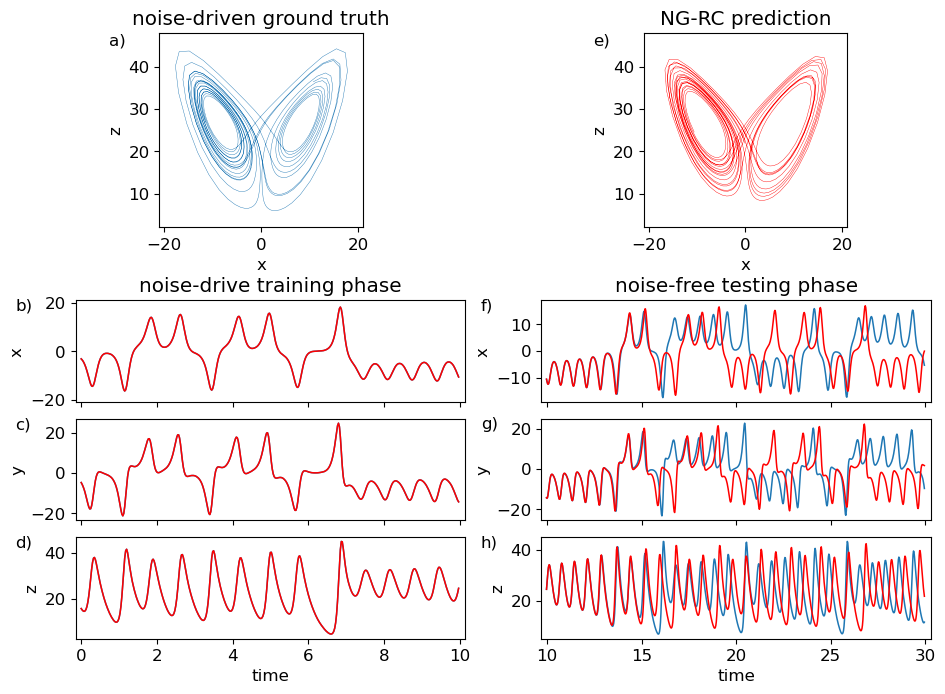

In [7]:

##
## Parameters
##

# time step
dt=0.025
# units of time to warm up NVAR. need to have warmup_pts >= 1
warmup = 5.
# units of time to train for
traintime = 10.
# units of time to test for
testtime=20.
# total time to run for
maxtime = warmup+traintime+testtime
# how much of testtime to plot
plottime=20.
# Lyapunov time of the Lorenz system
lyaptime=1.104

# discrete-time versions of the times defined above
warmup_pts=round(warmup/dt)
traintime_pts=round(traintime/dt)
warmtrain_pts=warmup_pts+traintime_pts
testtime_pts=round(testtime/dt)
maxtime_pts=round(maxtime/dt)
plottime_pts=round(plottime/dt)
lyaptime_pts=round(lyaptime/dt)

# input dimension
d = 3
# number of time delay taps
k = 2
# size of linear part of feature vector
dlin = k*d
# size of nonlinear part of feature vector
dnonlin = int(dlin*(dlin+1)/2)
# total size of feature vector: constant + linear + nonlinear
dtot = 1 + dlin + dnonlin

# ridge parameter for regression
ridge_param = 1.4e-2

# t values for whole evaluation time
# (need maxtime_pts + 1 to ensure a step of dt)
t_eval=np.linspace(0,maxtime,maxtime_pts+1)

# generate Gaussian random numbers at step dt and then interpolate for integrator
rng = np.random.default_rng(seed=1)

# width of the Gaussian distribution
width=1.

xran=rng.normal(0.,width,maxtime_pts+1)
yran=rng.normal(0.,width,maxtime_pts+1)
zran=rng.normal(0.,width,maxtime_pts+1)
xran_i = interp1d(t_eval,xran)
yran_i = interp1d(t_eval,yran)
zran_i = interp1d(t_eval,zran)

lorenz_soln_nf=np.zeros((d,maxtime_pts+1))

##
## Lorenz '63
##

sigma = 10
beta = 8 / 3
rho = 28

def lorenz(t, y):
  
  dy0 = sigma * (y[1] - y[0]) + xran_i(t)
  dy1 = y[0] * (rho - y[2]) - y[1] + yran_i(t)
  dy2 = y[0] * y[1] - beta * y[2] + zran_i(t)
  
  # since lorenz is 3-dimensional, dy/dt should be an array of 3 values
  return [dy0, dy1, dy2]

# No noise derivative
def lorenz_nn(t, y):
  
  dy0 = sigma * (y[1] - y[0]) 
  dy1 = y[0] * (rho - y[2]) - y[1] 
  dy2 = y[0] * y[1] - beta * y[2] 
  
  # since lorenz is 3-dimensional, dy/dt should be an array of 3 values
  return [dy0, dy1, dy2]

# I integrated out to t=50 to find points on the attractor, then use these as the initial conditions

lorenz_soln = solve_ivp(lorenz, (0, maxtime), [17.67715816276679, 12.931379185960404, 43.91404334248268] , t_eval=t_eval, method='RK23')


# total variance of Lorenz solution
total_var=np.var(lorenz_soln.y[0,:])+np.var(lorenz_soln.y[1,:])+np.var(lorenz_soln.y[2,:])

print('standard deviation for x,y,z: '+str(np.std(lorenz_soln.y[0,:]))+' '+str(np.std(lorenz_soln.y[1,:]))+' '+str(np.std(lorenz_soln.y[2,:])))

##
## NVAR
##

# create an array to hold the linear part of the feature vector
x = np.zeros((dlin,maxtime_pts))

# fill in the linear part of the feature vector for all times
for delay in range(k):
    for j in range(delay,maxtime_pts):
        x[d*delay:d*(delay+1),j]=lorenz_soln.y[:,j-delay]

# create an array to hold the full feature vector for training time
# (use ones so the constant term is already 1)
out_train = np.ones((dtot,traintime_pts))

# copy over the linear part (shift over by one to account for constant)
out_train[1:dlin+1,:]=x[:,warmup_pts-1:warmtrain_pts-1]

# fill in the non-linear part
cnt=0
for row in range(dlin):
    for column in range(row,dlin):
        # shift by one for constant
        out_train[dlin+1+cnt]=x[row,warmup_pts-1:warmtrain_pts-1]*x[column,warmup_pts-1:warmtrain_pts-1]
        cnt += 1

# ridge regression: train W_out to map out_train to Lorenz[t] - Lorenz[t - 1]
W_out = (x[0:d,warmup_pts:warmtrain_pts]-x[0:d,warmup_pts-1:warmtrain_pts-1]) @ out_train[:,:].T @ np.linalg.pinv(out_train[:,:] @ out_train[:,:].T + ridge_param*np.identity(dtot))

# apply W_out to the training feature vector to get the training output
x_predict = x[0:d,warmup_pts-1:warmtrain_pts-1] + W_out @ out_train[:,0:traintime_pts]

# calculate NRMSE between true Lorenz and training output
rms = np.sqrt(np.mean((x[0:d,warmup_pts:warmtrain_pts]-x_predict[:,:])**2)/total_var)
print('training nrmse: '+str(rms))

# create a place to store feature vectors for prediction
out_test = np.zeros(dtot)              # full feature vector
x_test = np.zeros((dlin,testtime_pts)) # linear part

# copy over initial linear feature vector
x_test[:,0] = x[:,warmtrain_pts-1]

# do prediction
for j in range(testtime_pts-1):
    # copy linear part into whole feature vector
    out_test[1:dlin+1]=x_test[:,j] # shift by one for constant
    # fill in the non-linear part
    cnt=0
    for row in range(dlin):
        for column in range(row,dlin):
            # shift by one for constant
            out_test[dlin+1+cnt]=x_test[row,j]*x_test[column,j]
            cnt += 1
    # fill in the delay taps of the next state
    x_test[d:dlin,j+1]=x_test[0:(dlin-d),j]
    # do a prediction
    x_test[0:d,j+1] = x_test[0:d,j]+W_out @ out_test[:]

# no noise solution
t_eval_nn=np.linspace(0,testtime,testtime_pts+1)
lorenz_soln_nn = solve_ivp(lorenz, (0,testtime), x_test[0:d,0] , t_eval=t_eval_nn, method='RK23')

# calculate NRMSE between true Lorenz and prediction for one Lyapunov time
total_var_nn=np.var(lorenz_soln_nn.y[0,:])+np.var(lorenz_soln_nn.y[1,:])+np.var(lorenz_soln_nn.y[2,:])
test_nrmse = np.sqrt(np.mean((lorenz_soln_nn.y[0:d,0:lyaptime_pts]-x_test[0:d,0:lyaptime_pts])**2)/total_var_nn)
print('NRMSE Loss: '+str(test_nrmse))

# calculate MSE 
test_mse = test_nrmse * test_nrmse * total_var
print('MSE Loss: '+str(test_mse))

##
## Plot
##

t_linewidth=1.1
a_linewidth=0.3
plt.rcParams.update({'font.size': 12})

fig1 = plt.figure()
fig1.set_figheight(8)
fig1.set_figwidth(12)

xlabel=[10,15,20,25,30,35,40]
h=120
w=100

# top left of grid is 0,0
axs1 = plt.subplot2grid(shape=(h,w), loc=(0, 9), colspan=22, rowspan=38) 
axs2 = plt.subplot2grid(shape=(h,w), loc=(52, 0), colspan=42, rowspan=20)
axs3 = plt.subplot2grid(shape=(h,w), loc=(75, 0), colspan=42, rowspan=20)
axs4 = plt.subplot2grid(shape=(h,w), loc=(98, 0), colspan=42, rowspan=20)
axs5 = plt.subplot2grid(shape=(h,w), loc=(0, 61), colspan=22, rowspan=38)
axs6 = plt.subplot2grid(shape=(h,w), loc=(52, 50),colspan=42, rowspan=20)
axs7 = plt.subplot2grid(shape=(h,w), loc=(75, 50), colspan=42, rowspan=20)
axs8 = plt.subplot2grid(shape=(h,w), loc=(98, 50), colspan=42, rowspan=20)

# true NOISY Lorenz attractor
axs1.plot(x[0,warmtrain_pts:maxtime_pts],x[2,warmtrain_pts:maxtime_pts],linewidth=a_linewidth)
axs1.set_xlabel('x')
axs1.set_ylabel('z')
axs1.set_title('noise-driven ground truth')
axs1.text(-.25,.92,'a)', ha='left', va='bottom',transform=axs1.transAxes)
axs1.axes.set_xbound(-21,21)
axs1.axes.set_ybound(2,48)

# training phase x
axs2.set_title('noise-drive training phase') 
axs2.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x[0,warmup_pts:warmtrain_pts],linewidth=t_linewidth)
axs2.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x_predict[0,:],linewidth=t_linewidth, color='r')
axs2.set_ylabel('x')
axs2.text(-.155,0.87,'b)', ha='left', va='bottom',transform=axs2.transAxes)
axs2.axes.xaxis.set_ticklabels([])
axs2.axes.set_ybound(-21.,21.)
axs2.axes.set_xbound(-.15,10.15)

# training phase y
axs3.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x[1,warmup_pts:warmtrain_pts],linewidth=t_linewidth)
axs3.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x_predict[1,:],linewidth=t_linewidth,color='r')
axs3.set_ylabel('y')
axs3.text(-.155,0.87,'c)', ha='left', va='bottom',transform=axs3.transAxes)
axs3.axes.xaxis.set_ticklabels([])
axs3.axes.set_xbound(-.15,10.15)

# training phase z
axs4.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x[2,warmup_pts:warmtrain_pts],linewidth=t_linewidth)
axs4.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x_predict[2,:],linewidth=t_linewidth,color='r')
axs4.set_ylabel('z')
axs4.text(-.155,0.87,'d)', ha='left', va='bottom',transform=axs4.transAxes)
axs4.set_xlabel('time')
axs4.axes.set_xbound(-.15,10.15)

# prediction attractor
axs5.plot(x_test[0,:],x_test[2,:],linewidth=a_linewidth,color='r')
axs5.set_xlabel('x')
axs5.set_ylabel('z')
axs5.set_title('NG-RC prediction')
axs5.text(-.25,0.92,'e)', ha='left', va='bottom',transform=axs5.transAxes)
axs5.axes.set_xbound(-21,21)
axs5.axes.set_ybound(2,48)

# testing phase x
axs6.set_title('noise-free testing phase')
axs6.set_xticks(xlabel)
axs6.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,lorenz_soln_nn.y[0,0:plottime_pts],linewidth=t_linewidth)
axs6.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,x_test[0,0:plottime_pts],linewidth=t_linewidth,color='r')
axs6.set_ylabel('x')
axs6.text(-.155,0.87,'f)', ha='left', va='bottom',transform=axs6.transAxes)
axs6.axes.xaxis.set_ticklabels([])
axs6.axes.set_xbound(9.7,30.3)

# testing phase y
axs7.set_xticks(xlabel)
axs7.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,lorenz_soln_nn.y[1,0:plottime_pts],linewidth=t_linewidth)
axs7.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,x_test[1,0:plottime_pts],linewidth=t_linewidth,color='r')
axs7.set_ylabel('y')
axs7.text(-.155,0.87,'g)', ha='left', va='bottom',transform=axs7.transAxes)
axs7.axes.xaxis.set_ticklabels([])
axs7.axes.set_xbound(9.7,30.3)

# testing phase z
axs8.set_xticks(xlabel)
axs8.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,lorenz_soln_nn.y[2,0:plottime_pts],linewidth=t_linewidth)
axs8.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,x_test[2,0:plottime_pts],linewidth=t_linewidth,color='r')
axs8.set_ylabel('z')
axs8.text(-.155,0.87,'h)', ha='left', va='bottom',transform=axs8.transAxes)
axs8.set_xlabel('time')
axs8.axes.set_xbound(9.7,30.3)

plt.savefig('predict-lorenz-noisy.png')
plt.savefig('predict-lorenz-noisy.svg')
plt.savefig('predict-lorenz-noisy.eps')
plt.savefig('predict-lorenz-noisy.pdf')
